# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot Image Dataset
- **Nama:** Anju Anjannah
- **Email:** anjannahanju@gmail.com
- **ID Dicoding:** anjunjnnh

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anjuanjannah","key":"723d9965b22f8a50bad7b08951b32b06"}'}

In [3]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflatin

In [5]:
directory = "Shoe vs Sandal vs Boot Dataset"

categories = ["Boot", "Sandal","Shoe"]

filenames = []
category_labels = []

# Iterate through the categories
for category in categories:
    # Path to the current category folder
    category_folder = os.path.join(directory, category)
    # List all filenames in the category folder
    category_filenames = os.listdir(category_folder)
    # Append filenames and corresponding category labels
    filenames.extend(category_filenames)
    category_labels.extend([category] * len(category_filenames))

In [6]:
# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})

# Display the first few rows of the DataFrame
print(df.head())

          filename category
0  boot (4695).jpg     Boot
1  boot (2280).jpg     Boot
2  boot (2649).jpg     Boot
3  boot (3872).jpg     Boot
4  boot (4135).jpg     Boot


In [7]:
# convert the filenames and class names to NumPy arrays
filenames = np.array(filenames)
labels = np.array(category_labels)

#### Split Dataset

In [8]:
!pip install split-folders
import splitfolders
# Specify the input directory containing the dataset and the output directory for the splits
input_folder = 'Shoe vs Sandal vs Boot Dataset' # Changed to your dataset directory
output_folder = 'output'
# Split the dataset into train, validation, and test sets with a ratio of 80%, 10%, 10%
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 15000 files [00:01, 8243.57 files/s]


### Data Preprocessing

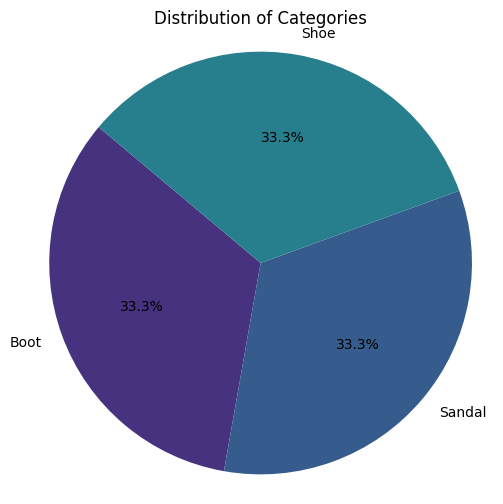

In [9]:
count = df['category'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6) , facecolor='White')
palette = sns.color_palette("viridis")
sns.set_palette(palette)
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')

plt.show()

In [10]:
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

# Mendefinisikan ukuran batch
batch_size = 32
image_size = (128, 128)
SEED = 123

In [11]:
# Augmentasi Data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_dg = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=SEED
        )

validation_dg = val_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=SEED
        )

test_dg = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=SEED
        )

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [13]:
class_indices_train = train_dg.class_indices

# Print the class indices
print("Class indices for training generator:", class_indices_train)

Class indices for training generator: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}


## Modelling

In [14]:
from tensorflow.keras.initializers import he_normal

# Sequential Model
model = Sequential()

# First Convolution Layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',
                 kernel_initializer=he_normal(), input_shape=(128, 128, 3), name='CONV_Layer1'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())

# Second Convolution Layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                 kernel_initializer=he_normal(), name='CONV_Layer2'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())
# Drop Out
model.add(Dropout(0.40))

# 3 Convolution Layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                 kernel_initializer=he_normal(), name='CONV_Layer3'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(BatchNormalization())
# Drop Out
model.add(Dropout(0.40))

# Flatten
model.add(Flatten(name='Flatten'))

# Fully Connected Layer
model.add(Dense(220, activation='relu', kernel_initializer=he_normal(), name='FullyConnected1'))
model.add(Dense(64,activation="relu"))

# Output Layer
model.add(Dense(3, activation='softmax', kernel_initializer=he_normal(), name='OutputLayer'))

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CONV_Layer1 (Conv2D)            │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_Layer2 (Conv2D)            │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV_Layer3 (Conv2D)            │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FullyConnected1 (Dense)         │ (None, 220)            │     1,802,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,846,815 (7.05 MB)

 Trainable params: 1,846,559 (7.04 MB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
#Complie
model.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

In [16]:
#Early_Stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=3,
    restore_best_weights=True,
)

#Fitting Model
history = model.fit(train_dg,
                        epochs= 30,
                        steps_per_epoch = len(train_dg),
                        validation_data = validation_dg,
                        validation_steps = len(validation_dg),
                        callbacks = early_stopping)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.8364 - loss: 0.4348 - val_accuracy: 0.8040 - val_loss: 0.5116
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9499 - loss: 0.1390 - val_accuracy: 0.9367 - val_loss: 0.1709
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9668 - loss: 0.0942 - val_accuracy: 0.9767 - val_loss: 0.0683
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9768 - loss: 0.0606 - val_accuracy: 0.9720 - val_loss: 0.0902
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9841 - loss: 0.0417 - val_accuracy: 0.9660 - val_loss: 0.1248
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9897 - loss: 0.0308 - val_accuracy: 0.9447 - val_loss: 0.1704


## Evaluasi dan Visualisasi

In [17]:
# Evaluasi model di dataset validasi
validation_loss, validation_accuracy = model.evaluate(validation_dg)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9728 - loss: 0.0771
Validation Loss: 0.06833109259605408
Validation Accuracy: 0.9766666889190674


In [18]:
# Evaluasi model di dataset validasi
test_loss, test_accuracy = model.evaluate(test_dg)

# Print the validation loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9721 - loss: 0.0801
Test Loss: 0.08685798197984695
Test Accuracy: 0.9693333506584167


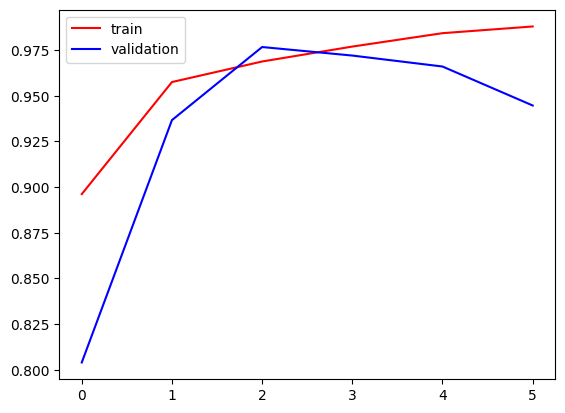

In [19]:
# Visualisasi Accuracy and Val_Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

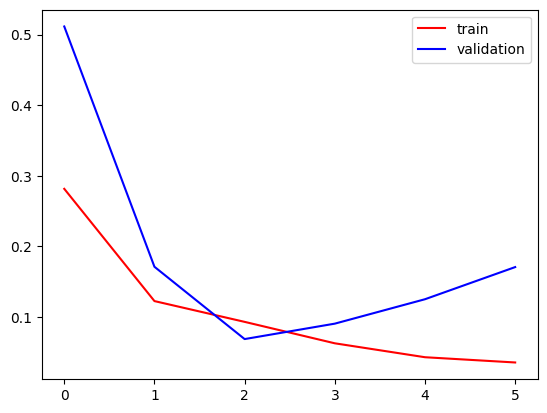

In [20]:
# Visualisasi Loss and Val_Loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

SavedModel

In [21]:
save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

Konversi Model TensorFlow ke TensorFlow.js

In [22]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [23]:
!tensorflowjs_converter \
--input_format=tf_saved_model \
--output_node_names='output' \
--saved_model_tags=serve \
mymodel/ \
mymodel_tfjs/

2025-04-22 02:21:02.729895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745288462.749519    1765 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745288462.755445    1765 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-22 02:21:12.687293: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745288472.687515    1765 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

Konversi Model TensorFlow ke TF-Lite

In [24]:
tf.saved_model.save(model, save_path)

# Convert SavedModel menjadi mymodel.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('mymodel.tflite')
tflite_model_file.write_bytes(tflite_model)

16772

In [25]:
# Daftar kata yang ingin disimpan
words = ["boot", "sandal", "shoe"]

# Menyimpan kata-kata ke dalam file .txt
with open('label.txt', 'w') as file:
    for word in words:
        file.write(word + '\n')  # Menulis setiap kata di baris baru

print("Kata-kata telah disimpan ke dalam 'label.txt'")

Kata-kata telah disimpan ke dalam 'label.txt'


## Inference

In [26]:
# Muat SavedModel
loaded_model = tf.saved_model.load(save_path)

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path ke gambar yang akan diprediksi - Ganti dengan path gambar yang benar
# Make sure the path is correct and the image exists
image_path = 'output/test/Boot/boot (101).jpg'

# Check if the file exists
if not os.path.exists(image_path):
    # Print error if not
    print(f"Error: Image file not found at {image_path}")
    # Optionally, you could use a different image path here
else:
    # Proceed with image loading if file exists
    img = image.load_img(image_path, target_size=(128, 128))

    # Ubah gambar menjadi array NumPy
    img_array = image.img_to_array(img)

    # Praproses gambar
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

In [33]:
# Lakukan prediksi
# Get the prediction function from the loaded model
infer = loaded_model.signatures['serving_default']

# Perform the prediction
predictions = infer(tf.constant(img_array))['output_0']

# Dapatkan label prediksi
predicted_class_index = np.argmax(predictions)

# Dapatkan nama kelas
class_names = ['Boot', 'Sandal', 'Shoe']
predicted_class_name = class_names[predicted_class_index]

# Cetak hasil prediksi
print("Prediksi:", predicted_class_name)

Prediksi: Boot


In [27]:
pip freeze > requirements.txt